<font color='red'>后面模型绘制K-fold CV的图错了</font>

# **Taiwan Bankruptcy Classification ML Project**

<a class="anchor" id="0.1"></a>
## Table of Contents

- 1 [Libraries](#1)
- 2 [Data Preview](#2)
- 3 [Outlier Detection](#3)
- 4 [Correlation Analysis](#4)
- 5 [Train Models](#6)
   - 5.1 [Define Global Variables & Utilts](#6.1)
   - 5.2 [Logistic Regression](#6.2)
   - 5.3 [Decision Tree](#6.3)
   - 5.4 [Random Forest](#6.4)
   - 5.5 [Support Vector Machine](#6.5)
   - 5.6 [XGBoost](#6.6)
- 6 [Comparison of Models](#7)

### Libraries <a class="anchor" id="1"></a>

[Table of Contents](#0.1)

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as spi
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from skopt import BayesSearchCV
import xgboost as xgb
# from sklearn.pipeline import Pipeline  # can't use SMOTE in pipeline
from imblearn.pipeline import Pipeline
import pickle
import os

random_state = 42

### Data Preview <a class="anchor" id="2"></a>

[Table of Contents](#0.1)

In [3]:
df = pd.read_excel("data/Taiwan+Bankruptcy+Dataset.xlsx", sheet_name='Taiwan Bankruptcy Data')
df

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [4]:
# whether there exists values greater than 1?
(df>1).values.sum()

24940

In [5]:
# whether there exist missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt                                                  6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [6]:
# inspecting null values
df.isnull().sum().sum()

0

In [7]:
# have a glance at the features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Bankrupt,6819.0,0.032263,0.176710,0.0,0.000000,0.000000,0.000000,1.0
ROA(C) before interest and depreciation before interest,6819.0,0.505180,0.060686,0.0,0.476527,0.502706,0.535563,1.0
ROA(A) before interest and % after tax,6819.0,0.558625,0.065620,0.0,0.535543,0.559802,0.589157,1.0
ROA(B) before interest and depreciation after tax,6819.0,0.553589,0.061595,0.0,0.527277,0.552278,0.584105,1.0
Operating Gross Margin,6819.0,0.607948,0.016934,0.0,0.600445,0.605997,0.613914,1.0
...,...,...,...,...,...,...,...,...
Liability to Equity,6819.0,0.280365,0.014463,0.0,0.276944,0.278778,0.281449,1.0
Degree of Financial Leverage (DFL),6819.0,0.027541,0.015668,0.0,0.026791,0.026808,0.026913,1.0
Interest Coverage Ratio (Interest expense to EBIT),6819.0,0.565358,0.013214,0.0,0.565158,0.565252,0.565725,1.0
Net Income Flag,6819.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


In [8]:
# Drop uninformative feature
df.drop(' Net Income Flag', axis=1, inplace=True) if ' Net Income Flag' in df.columns else None

0    6599
1     220
Name: Bankrupt, dtype: int64

The banckruptcy proportion is roughly  3.23%


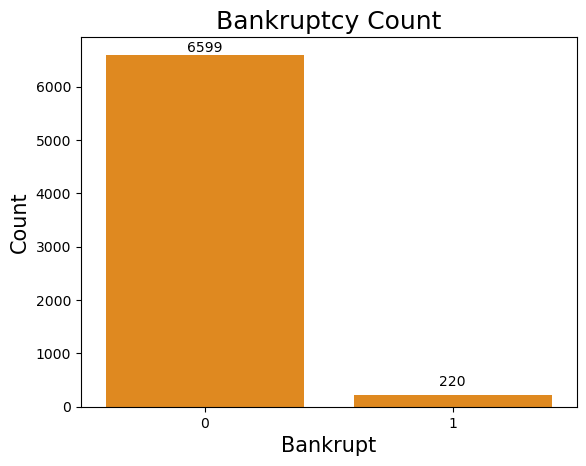

In [9]:
# Examine the proportion of the target variable in full dataset
bankrupt_count_table = df['Bankrupt'].value_counts()
print(bankrupt_count_table)
proportion = bankrupt_count_table[1] / (bankrupt_count_table[0] + bankrupt_count_table[1])
print(f"\nThe banckruptcy proportion is roughly {proportion * 100: .2f}%")

# Plot bars to show the proportion of the target variable
plt.figure()
ax = sns.countplot(x='Bankrupt', data=df, color='darkorange')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() * 0.98),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title("Bankruptcy Count", fontsize=18)
plt.xlabel("Bankrupt", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

Hence the data is extremely imbalanced.

### Outlier Detection <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

#### Try LOF

In [10]:
# use LOF to remove outliers and plot boxplot for features with > 1 values
lof = LocalOutlierFactor(n_neighbors=20)
X_pred = lof.fit_predict(df.iloc[:, 1:].to_numpy())
dftt = df.loc[X_pred == 1, :]
dft = dftt.loc[:, (dftt > 1).any(axis=0)]

In [11]:
# # dftt
# cols_per_part = dft.shape[1] // 4
# split_parts = [dft.iloc[:, i*cols_per_part:(i+1)*cols_per_part] for i in range(3)] + [dft.iloc[:, 3*cols_per_part:]]

# fig, ax = plt.subplots(2, 2, figsize=(20, 10))
# ax = ax.flatten()
# x_idx = np.cumsum([0] + [split_part.shape[1] for split_part in split_parts])
# for i, part_df in enumerate(split_parts):
#     n_col = part_df.shape[1]
#     sns.boxplot(data=part_df, ax=ax[i], color='skyblue')
#     ax[i].set_xticks(range(n_col), part_df.columns, rotation=45)
#     # ax[i].set_xticks(range(n_col), np.arange(x_idx[i], x_idx[i + 1]), rotation=45)
    
# plt.subplots_adjust(hspace=1)
# plt.show()

In [12]:
dftt['Bankrupt'].value_counts().to_dict()

{0: 6003, 1: 173}

<font color='red'>The result is LOF is not suitable for this dataset.</font>

#### Try manually outlier detection and processing <font color="red">(More specifically, I think they are noise, caused by errors in data collection and carrying no meaningful information, not outliers.)</font>

In [13]:
# define a temporary dataframe for plotting, which selects features with values > 1
dft = df.loc[:, (df > 1).any(axis=0)]
dft.describe().T

,count,mean,std,min,25%,50%,75%,max
Operating Expense Rate,6819.0,1.995347e+09,3.237684e+09,0.0,1.566874e-04,2.777589e-04,4.145000e+09,9.990000e+09
Research and development expense rate,6819.0,1.950427e+09,2.598292e+09,0.0,1.281880e-04,5.090000e+08,3.450000e+09,9.980000e+09
Interest-bearing debt interest rate,6819.0,1.644801e+07,1.082750e+08,0.0,2.030203e-04,3.210321e-04,5.325533e-04,9.900000e+08
Revenue Per Share (Yuan Â¥),6819.0,1.328641e+06,5.170709e+07,0.0,1.563138e-02,2.737571e-02,4.635722e-02,3.020000e+09
Total Asset Growth Rate,6819.0,5.508097e+09,2.897718e+09,0.0,4.860000e+09,6.400000e+09,7.390000e+09,9.990000e+09
Net Value Growth Rate,6819.0,1.566212e+06,1.141594e+08,0.0,4.409689e-04,4.619555e-04,4.993621e-04,9.330000e+09
Current Ratio,6819.0,4.032850e+05,3.330216e+07,0.0,7.555047e-03,1.058717e-02,1.626953e-02,2.750000e+09
Quick Ratio,6819.0,8.376595e+06,2.446847e+08,0.0,4.725903e-03,7.412472e-03,1.224911e-02,9.230000e+09
Total debt/Total net worth,6819.0,4.416337e+06,1.684069e+08,0.0,3.007049e-03,5.546284e-03,9.273293e-03,9.940000e+09
Accounts Receivable Turnover,6819.0,1.278971e+07,2.782598e+08,0.0,7.101336e-04,9.678107e-04,1.454759e-03,9.740000e+09


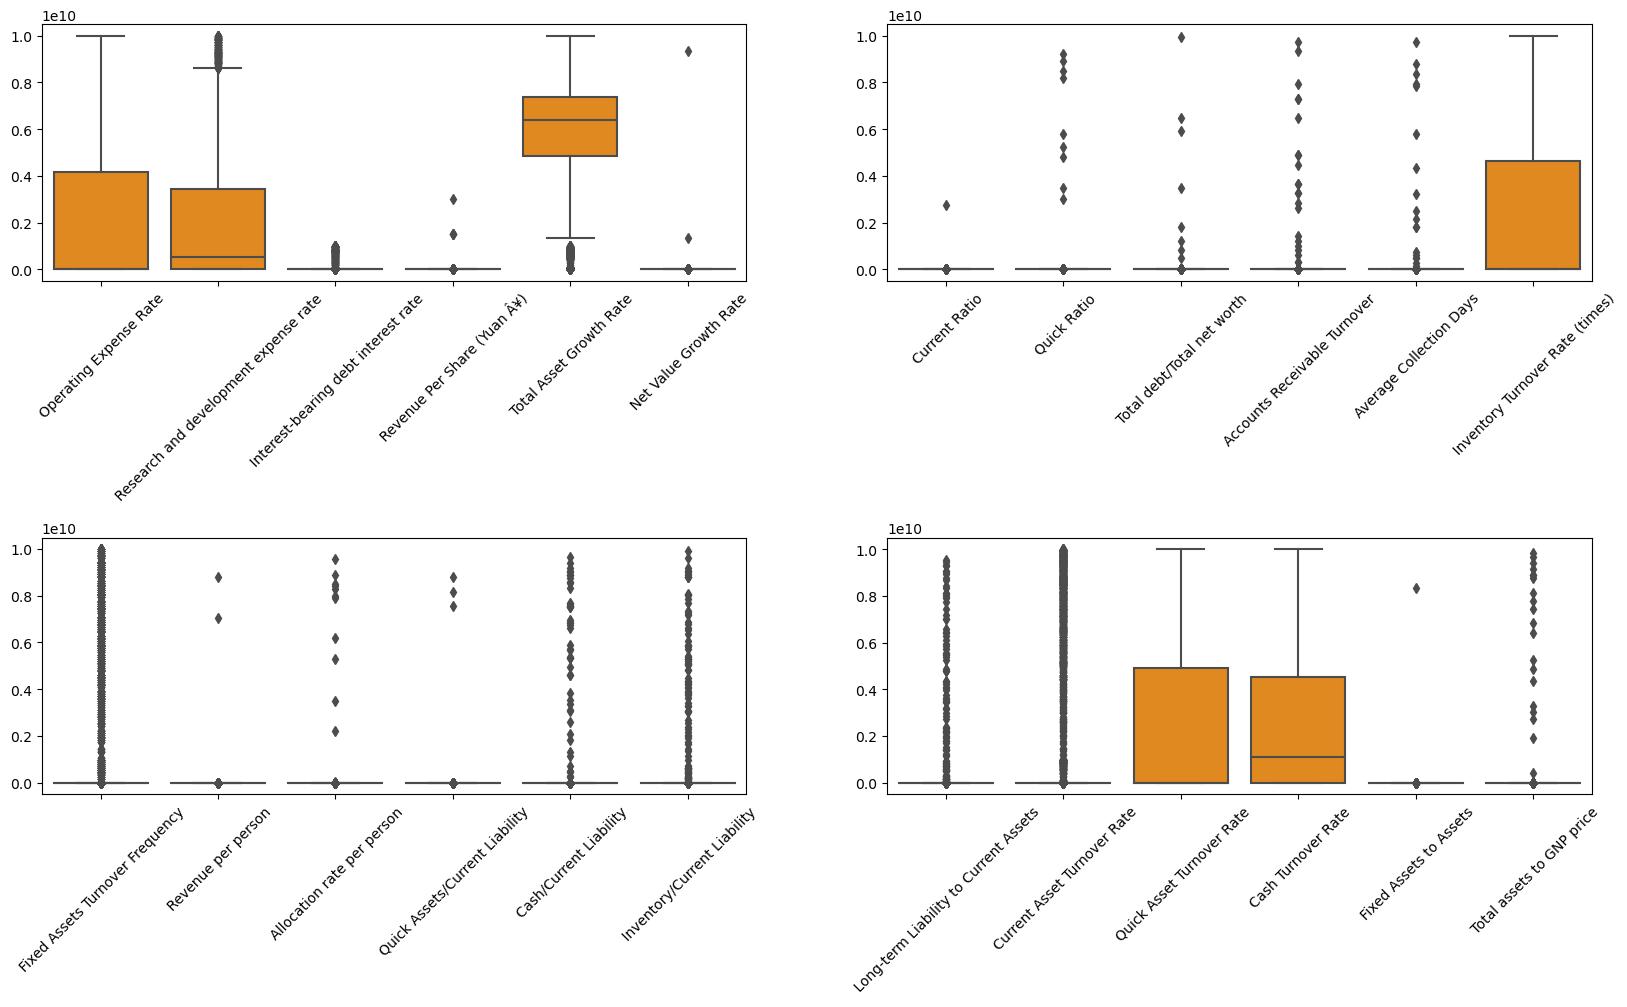

In [14]:
# Draw boxplot for this features with 'outliers' 
cols_per_part = dft.shape[1] // 4
split_parts = [dft.iloc[:, i*cols_per_part:(i+1)*cols_per_part] for i in range(3)] + [dft.iloc[:, 3*cols_per_part:]]

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.flatten()
x_idx = np.cumsum([0] + [split_part.shape[1] for split_part in split_parts])
for i, part_df in enumerate(split_parts):
    n_col = part_df.shape[1]
    sns.boxplot(data=part_df, ax=ax[i], color='darkorange')
    ax[i].set_xticks(range(n_col), part_df.columns, rotation=45)
    # ax[i].set_xticks(range(n_col), np.arange(x_idx[i], x_idx[i + 1]), rotation=45)
    
plt.subplots_adjust(hspace=1)
plt.show()

In [15]:
# get the outlier count for each feature with label info
outlier_df = pd.DataFrame(index=[0, 1])
for col in dft.columns:
    s = df[df[col] > 1]['Bankrupt'].value_counts().rename(col, inplace=True)
    outlier_df = pd.concat([outlier_df, s], axis=1)

# fillna with 0, transpose, and get the sum over label axis
outlier_df.fillna(0, inplace=True)
outlier_df = outlier_df.T
outlier_df['sum'] = outlier_df.sum(axis=1)
outlier_df = outlier_df.astype(int)
outlier_df.rename(columns={0: 'non-bankrupt', 1: 'bankrupt'}, inplace=True)
outlier_df

,non-bankrupt,bankrupt,sum
Operating Expense Rate,2215,67,2282
Research and development expense rate,3913,120,4033
Interest-bearing debt interest rate,219,2,221
Revenue Per Share (Yuan Â¥),5,0,5
Total Asset Growth Rate,5805,212,6017
Net Value Growth Rate,1,1,2
Current Ratio,1,0,1
Quick Ratio,8,1,9
Total debt/Total net worth,7,1,8
Accounts Receivable Turnover,21,1,22


In [16]:
# Drop features with > 1000 outliers
df_dropped_feature = df.loc[:, ~df.columns.isin(outlier_df.index[outlier_df['sum'] > 1000])]

# Then drop samples with outliers
df_cleaned = df_dropped_feature.loc[~(df_dropped_feature > 1).any(axis=1), :]

In [17]:
print('The label counts after outlier processing:\n', df_cleaned['Bankrupt'].value_counts(), sep='')

The label counts after outlier processing:
0    6090
1     191
Name: Bankrupt, dtype: int64


This approch dropped only around 30 samples in label 1, which is lower than the value of 50 with LOF method.

### Correlation Analysis <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

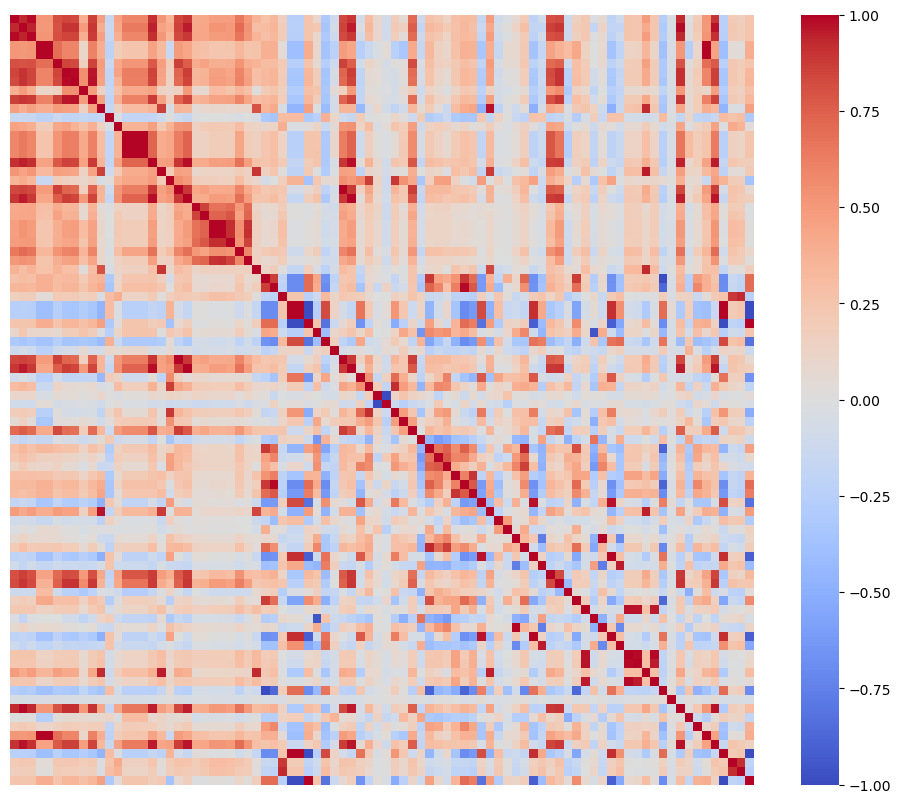

In [18]:
corr_matrix = df_cleaned.iloc[:, 1:].astype('float64').corr(method='spearman')

# visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", xticklabels=False, yticklabels=False)
plt.show()

### Train Models <a class="anchor" id="6"></a>

#### Define Global Variables & Utilts <a class="anchor" id="6.1"></a>

[Table of Contents](#0.1)

In [ ]:
# Get data as numpy array
X = df_cleaned.iloc[:, 1:].to_numpy()
y = df_cleaned.iloc[:, 0].to_numpy()

# Get the feature names
col_names = df_cleaned.iloc[:, 1:].columns
col_names = list(map(lambda x: x.strip(), col_names))

n = X.shape[1]
pipe = Pipeline(
    [
        ('scaling1', StandardScaler()),
        ('smote', SMOTE(random_state=random_state)),
    ]
)

In [21]:
# Set global variables
CV_NUM = 5
SCOREING_METHOD = {'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'f2': make_scorer(fbeta_score, beta=2),
                   'average_precision': 'average_precision', 'roc_auc': 'roc_auc'}
N_JOBS = -1
REFIT = 'f2'  # refit the model with the best f1 score

def get_pipe(classifier_name: str, classifier):
    scaler = StandardScaler()
    smote = SMOTE(random_state=random_state)

    pipe = Pipeline([
        ('scaling', scaler),
        ('smote', smote),
        (classifier_name, classifier)
    ])
    
    return pipe

# ! Note: the following two commented functions use the predicted proba from cross_val_predict to plot ROC and PR curve, which is not appropriate.
# ! Because the scores in GridSearchCV are calculated by cross_val_score, which is the mean of each fold's score. And it is a right way to measure the scores according to official docs.
# ! How ever, cross_val_predict will combine the predicted proba for all folds at ones. If we use its result to plot ROC and PR curve, the AP and AUC will be 'wrong'. 
# ! See: https://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation
# def plot_ROC(classifier_name: str, y_test, y_pred_proba):
#     # Plot ROC with AUC
#     # Calculate the ROC curve
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

#     # Calculate the AUC
#     auc = roc_auc_score(y_test, y_pred_proba)

#     # Plot the ROC curve
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{classifier_name} (AUC = {auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC of {classifier_name}')
#     plt.legend(loc='lower right')
#     plt.show()
    
# def plot_PR_curve(classifier_name: str, y_test, y_pred_proba):
#     # Plot PR curve
#     pr_display = PrecisionRecallDisplay.from_predictions(
#         y_test, y_pred_proba, name=classifier_name, color='darkorange', drawstyle="default", 
#         plot_chance_level=True, chance_level_kw={'color': 'navy'}
#     )
#     pr_display.ax_.set_title(f'PR Curve of {classifier_name}')
#     plt.show()
    
# ! The following two functions use the mean of tpf, fpr, precision, recall of k-fold to plot ROC and PR curve, which is appropriate according to the official docs.
def plot_PR_curve(classifier, classifier_name: str, cv_num: int):
    cv = StratifiedKFold(n_splits=cv_num)
    
    precisions = []
    aps = []
    mean_recall = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = PrecisionRecallDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=f"PR fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == cv_num - 1),
            chance_level_kw={"color": "navy"}
        )
        # linear interpolation
        interp_precision = np.interp(mean_recall, np.sort(viz.recall), np.sort(viz.precision)[::-1])
        
        interp_precision[-1] = 0.0
        precisions.append(interp_precision)
        aps.append(viz.average_precision)

    mean_precision = np.mean(precisions, axis=0)
    mean_precision[0] = 1.0
    mean_ap = auc(mean_recall, mean_precision)
    std_ap = np.std(aps)
    ax.plot(
        mean_recall,
        mean_precision,
        color="darkorange",
        label=r"Mean PR (AP = %0.2f $\pm$ %0.2f)" % (mean_ap, std_ap),
        lw=2,
        alpha=0.8,
    )

    std_precision = np.std(precisions, axis=0)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)
    ax.fill_between(
        mean_recall,
        precision_lower,
        precision_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title=f"Mean PR curve with variability ({classifier_name})",
    )
    ax.axis("square")
    ax.legend(loc="lower left")
    plt.show()

def plot_ROC(classifier, classifier_name: str, cv_num: int):
    cv = StratifiedKFold(n_splits=cv_num)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == cv_num - 1),
            chance_level_kw={"color": "navy"}
        )
        # linear interpolation
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="darkorange",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability ({classifier_name})",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()
    
# ! The confusion matrix is calculated by cross_val_predict, which is appropriate.
# ! Because each predicted proba in cross_val_predict corresponds to only one sample, which means each sample is only predicted once.
# ! Hence, the confusion matrix calculated in this way is just the sum of confusion matrices of each fold.
# ! If we want to get the mean confusion matrix, we can just divide the sum by the number of folds.
def calculate_type1_type2_error(y_test, y_pred, display_cm=True):
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
    if display_cm == True:
        print('Confusion Matrix:\n')
        display(cm_df)
    # Calculate type1 and type2 error
    tn, fp, fn, tp = cm.ravel()
    type1_error = fp / (fp + tn)
    type2_error = fn / (fn + tp)
    return type1_error, type2_error

#### Logistic Regression <a class="anchor" id="6.2"></a>

[Table of Contents](#0.1)

model: Logistic
The best parameter is: {'Logistic__C': 0.001, 'Logistic__l1_ratio': 0.5, 'Logistic__penalty': 'elasticnet'}
Confusion Matrix:



,Predicted Negative,Predicted Positive
Actual Negative,5169,921
Actual Positive,25,166


Model metrics:
precision            0.169376
recall               0.868691
f1                   0.280021
f2                   0.464685
average_precision    0.380788
roc_auc              0.921023
type1_error          0.151232
type2_error          0.130890
dtype: float64


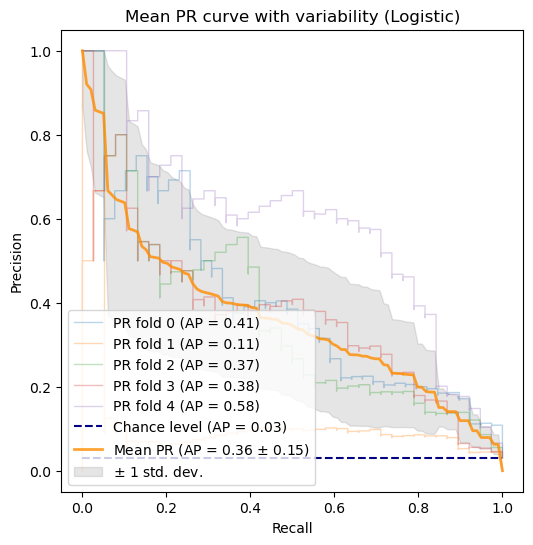

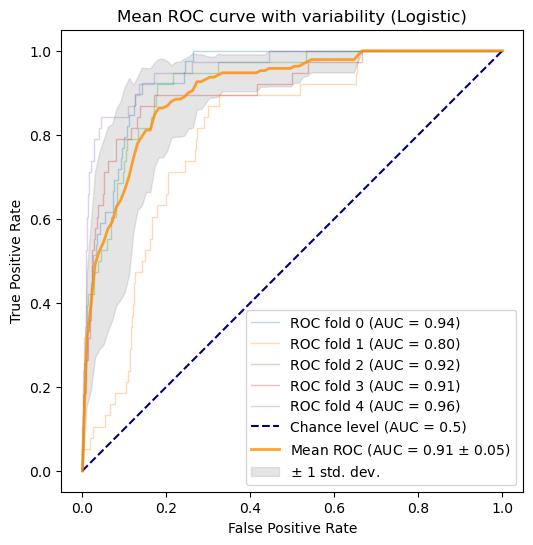

In [23]:
# Initialize the classifier and its name
classifier_name = 'Logistic'
classifier = LogisticRegression(max_iter=1000, solver='saga', random_state=random_state)

# Generate the pipeline
pipe = get_pipe(classifier_name, classifier)

# Grid search tuning params
# grid_params = {classifier_name + '__' + 'penalty': ['elasticnet'], classifier_name + '__' + 'l1_ratio': np.linspace(0, 1, 5), classifier_name + '__' + 'C': np.logspace(-3, 3, 7)}
grid_params = {classifier_name + '__' + 'C': [0.001], classifier_name + '__' + 'penalty': ['elasticnet'], classifier_name + '__' + 'l1_ratio': [0.5]}
search_logistic = GridSearchCV(pipe, param_grid=grid_params, scoring=SCOREING_METHOD, n_jobs=N_JOBS, refit=REFIT, cv=CV_NUM)
search_logistic.fit(X, y)

# Summarize the results
print('model:', classifier_name)
print('The best parameter is:', search_logistic.best_params_)
# print('The Accuracy for the best model is:', search_logistic.cv_results_['mean_test_accuracy'][search_logistic.best_index_])
# print('The F1-score for the best model is:', search_logistic.cv_results_['mean_test_f1'][search_logistic.best_index_])
data = [search_logistic.cv_results_['mean_test_' + scorer][search_logistic.best_index_] for scorer in SCOREING_METHOD.keys()]
index = [scorer for scorer in SCOREING_METHOD.keys()]
result_cv_logistic = pd.Series(data=data, index=index, name=classifier_name)

# Predict probabilities with cv and calculate type1 and type2 error
y_pred_proba_logistic = cross_val_predict(search_logistic.best_estimator_, X, y, cv=CV_NUM, method='predict_proba')[:, 1]  # proba of label 1
type1_error, type2_error = calculate_type1_type2_error(y, np.where(y_pred_proba_logistic > 0.5, 1, 0), display_cm=True)  # use 0.5 as threshold by default
result_cv_logistic = pd.concat([result_cv_logistic, pd.Series(data=[type1_error, type2_error], index=['type1_error', 'type2_error'])])
print('Model metrics:\n', result_cv_logistic, sep='')

# Plot PR curve and ROC
# plot_PR_curve(classifier_name, y, y_pred_proba_logistic)
plot_PR_curve(search_logistic.best_estimator_, classifier_name, CV_NUM)
plot_ROC(search_logistic.best_estimator_, classifier_name, CV_NUM)

In [312]:
# save and load model
model_path_logistic = './fitted_models/model_logistic.pkl'

if os.path.exists(model_path_logistic):
    # Load the best model with pickle
    with open(model_path_logistic, 'rb') as f:
        search_logistic = pickle.load(f)
        best_model_logistic = search_logistic.best_estimator_
elif 'search_logistic' in globals():
    # Dump the best model with pickle
    with open(model_path_logistic, 'wb') as f:
        pickle.dump(search_logistic, f)

In [313]:
# feature importance of logistic regression (criteria: abs of coef)
feature_selection_lostistic = pd.DataFrame(index=col_names, data=best_model_logistic.named_steps['Logistic'].coef_.T, columns=['coef'])
feature_selection_lostistic['abs_coef'] = np.abs(feature_selection_lostistic['coef'])
feature_selection_lostistic.sort_values(by='abs_coef', ascending=False, inplace=True)
feature_selection_lostistic = feature_selection_lostistic.loc[~(feature_selection_lostistic == 0).any(axis=1), :]
feature_selection_lostistic

,coef,abs_coef
Net worth/Assets,-0.420524,0.420524
Debt ratio %,0.420524,0.420524
Persistent EPS in the Last Four Seasons,-0.212445,0.212445
ROA(C) before interest and depreciation before interest,-0.201391,0.201391
Net Income to Total Assets,-0.171341,0.171341
ROA(B) before interest and depreciation after tax,-0.169420,0.169420
Working Capital to Total Assets,-0.153116,0.153116
Net profit before tax/Paid-in capital,-0.104669,0.104669
Total Asset Turnover,-0.099477,0.099477
Average Collection Days,0.084213,0.084213


Text(0.5, 1.0, 'Feature Importance of Logistic Regression')

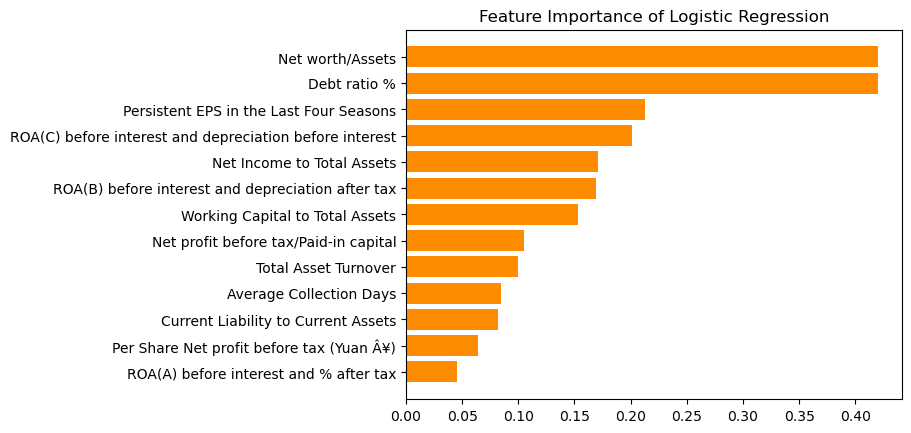

In [314]:
fig, ax = plt.subplots()
feature_selection_lostistic_filtered = feature_selection_lostistic['abs_coef'].sort_values()
ax.barh(feature_selection_lostistic_filtered.index, feature_selection_lostistic_filtered, color='darkorange')
ax.set_title('Feature Importance of Logistic Regression')

#### Decision Tree <a class="anchor" id="6.3"></a>

[Table of Contents](#0.1)

model: Tree
The best parameter is: {'Tree__max_depth': 5, 'Tree__min_samples_split': 11}
Confusion Matrix:



,Predicted Negative,Predicted Positive
Actual Negative,5304,786
Actual Positive,56,135


Model metrics:
precision            0.163125
recall               0.705938
f1                   0.259859
f2                   0.409722
average_precision    0.199341
roc_auc              0.809803
type1_error          0.129064
type2_error          0.293194
dtype: float64


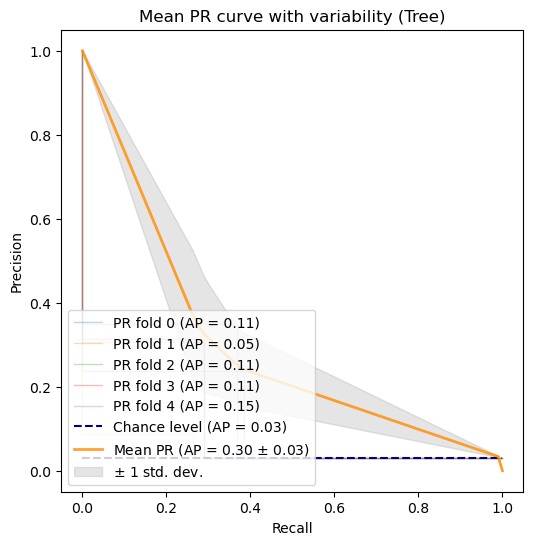

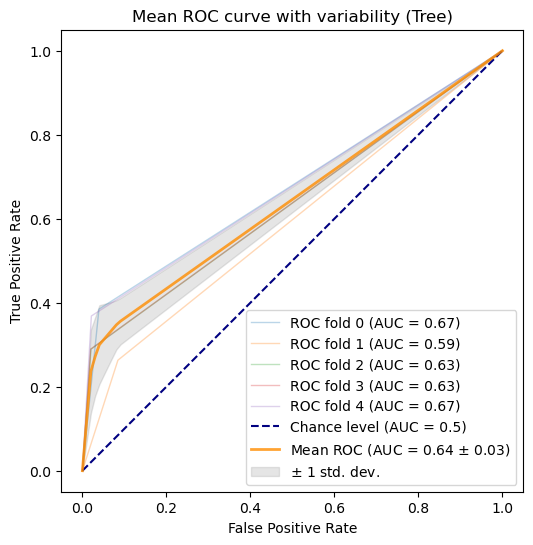

In [77]:
# Initialize the classifier and its name
classifier_name = 'Tree'
classifier = DecisionTreeClassifier(random_state=random_state)

# Generate the pipeline
pipe = get_pipe(classifier_name, classifier)

# Grid search tuning params
# grid_params = {classifier_name + '__' + 'max_depth': np.arange(5, 30, 2), classifier_name + '__' + 'min_samples_split': np.arange(2, 30, 3)}
grid_params = {classifier_name + '__' + 'max_depth': [5], classifier_name + '__' + 'min_samples_split': [11]}
search_tree = GridSearchCV(pipe, param_grid=grid_params, scoring=SCOREING_METHOD, n_jobs=N_JOBS, refit=REFIT, cv=CV_NUM)
search_tree.fit(X, y)

# Summarize the results
print('model:', classifier_name)
print('The best parameter is:', search_tree.best_params_)
data = [search_tree.cv_results_['mean_test_' + scorer][search_tree.best_index_] for scorer in SCOREING_METHOD.keys()]
index = [scorer for scorer in SCOREING_METHOD.keys()]
result_cv_tree = pd.Series(data=data, index=index, name=classifier_name)

# Predict probabilities with cv and calculate type1 and type2 error
y_pred_proba_tree = cross_val_predict(search_tree.best_estimator_, X, y, cv=CV_NUM, method='predict_proba')[:, 1]  # proba of label 1
type1_error, type2_error = calculate_type1_type2_error(y, np.where(y_pred_proba_tree > 0.5, 1, 0), display_cm=True)  # use 0.5 as threshold by default
result_cv_tree = pd.concat([result_cv_tree, pd.Series(data=[type1_error, type2_error], index=['type1_error', 'type2_error'])])
print('Model metrics:\n', result_cv_tree, sep='')

# Plot PR curve and ROC
plot_PR_curve(search_tree.best_estimator_, classifier_name, CV_NUM)
plot_ROC(search_tree.best_estimator_, classifier_name, CV_NUM)

<font color='red'>Note: The AP and AUC above for one *Single Classification* tree are not accurate, because the classification tree only output several countable probability for all samples, which will lead to only a few points can be plot on the figure. Hence the PR curve and ROC curve are not accurate.</font>

In [298]:
# save and load model
model_path_tree = './fitted_models/model_tree.pkl'

if os.path.exists(model_path_tree):
    # Load the best model with pickle
    with open(model_path_tree, 'rb') as f:
        search_tree = pickle.load(f)
        best_model_tree = search_tree.best_estimator_
elif 'search_tree' in globals():
    # Dump the best model with pickle
    with open(model_path_tree, 'wb') as f:
        pickle.dump(search_tree, f)

In [299]:
# feature importance of decision tree
feature_selection_tree = pd.DataFrame(index=col_names, data=best_model_tree.named_steps['Tree'].feature_importances_, columns=['Importance']).sort_values(by='Importance', ascending=False)
feature_selection_tree = feature_selection_tree.loc[~(feature_selection_tree == 0).any(axis=1), :]
feature_selection_tree

,Importance
Continuous interest rate (after tax),0.538849
Total debt/Total net worth,0.164016
Interest Expense Ratio,0.100950
Operating Profit Rate,0.028281
Average Collection Days,0.022624
Borrowing dependency,0.017693
Net Income to Stockholder's Equity,0.016074
Total income/Total expense,0.013502
Quick Ratio,0.011395
Interest-bearing debt interest rate,0.010665


In [300]:
feature_selection_tree['Importance'][feature_selection_tree['Importance'] > 0.01]

Continuous interest rate (after tax)    0.538849
Total debt/Total net worth              0.164016
Interest Expense Ratio                  0.100950
Operating Profit Rate                   0.028281
Average Collection Days                 0.022624
Borrowing dependency                    0.017693
Net Income to Stockholder's Equity      0.016074
Total income/Total expense              0.013502
Quick Ratio                             0.011395
Interest-bearing debt interest rate     0.010665
Name: Importance, dtype: float64

Text(0.5, 1.0, 'Feature Importance of Decision Tree')

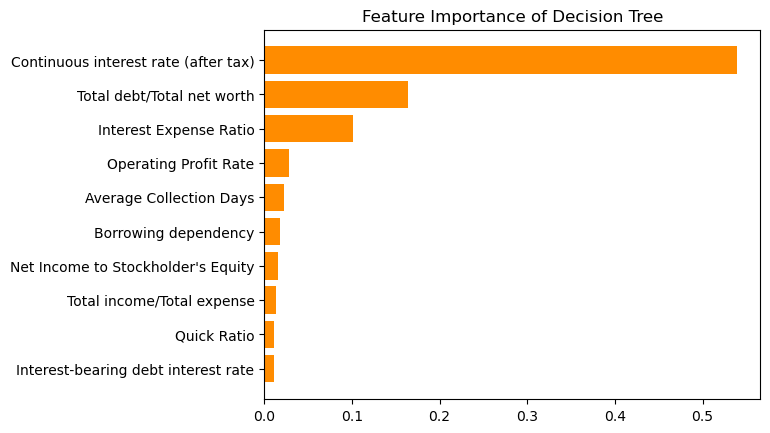

In [301]:
fig, ax = plt.subplots()
feature_selection_tree_filtered = feature_selection_tree['Importance'][feature_selection_tree['Importance'] > 0.01].sort_values()
ax.barh(feature_selection_tree_filtered.index, feature_selection_tree_filtered, color='darkorange')
ax.set_title('Feature Importance of Decision Tree')

#### Random Forest <a class="anchor" id="6.4"></a>

[Table of Contents](#0.1)

model: RF
The best parameter is: {'RF__max_depth': 7, 'RF__max_features': 9, 'RF__n_estimators': 100}
Confusion Matrix:



,Predicted Negative,Predicted Positive
Actual Negative,5562,528
Actual Positive,59,132


Model metrics:
precision            0.224212
recall               0.690418
f1                   0.331469
f2                   0.473407
average_precision    0.345583
roc_auc              0.925967
type1_error          0.086700
type2_error          0.308901
dtype: float64


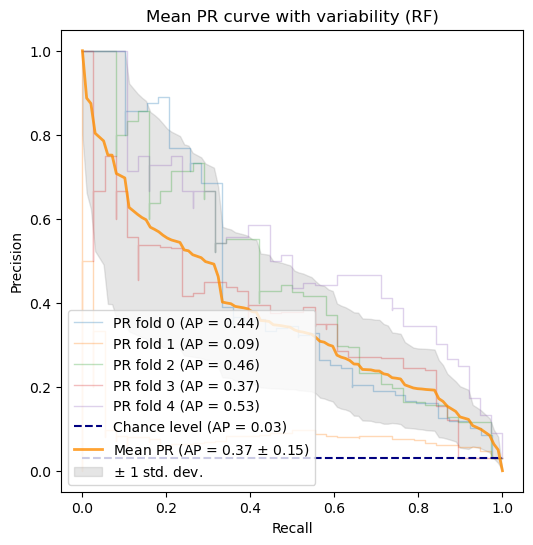

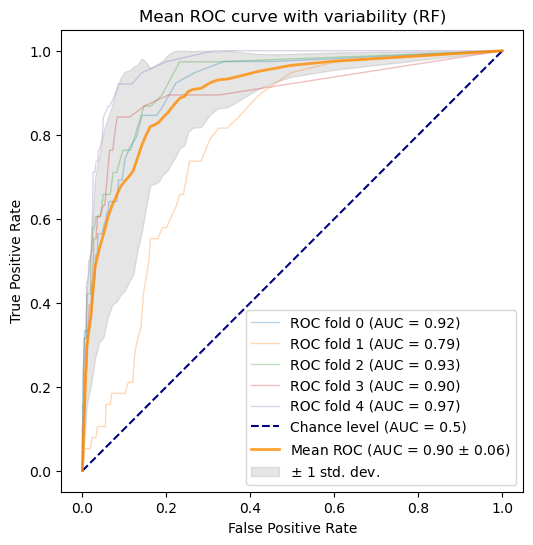

In [127]:
# Initialize the classifier and its name
classifier_name = 'RF'
classifier = RandomForestClassifier(random_state=random_state)

# Generate the pipeline
pipe = get_pipe(classifier_name, classifier)

# Grid search tuning params
# grid_params = {classifier_name + '__' + 'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}
# grid_params = {classifier_name + '__' + 'n_estimators': np.arange(60, 140, 10)}
# grid_params = {classifier_name + '__' + 'n_estimators': [100], 
#                 classifier_name + '__' + 'max_depth': [3, 5, 7],
#                classifier_name + '__' + 'max_features': np.arange(np.floor(np.sqrt(86)), 86, 10, dtype=int)}
grid_params = {classifier_name + '__' + 'n_estimators': [100], 
                classifier_name + '__' + 'max_depth': [7],
               classifier_name + '__' + 'max_features': [9]}
search_rf = GridSearchCV(pipe, param_grid=grid_params, scoring=SCOREING_METHOD, n_jobs=N_JOBS, refit=REFIT, cv=CV_NUM)
search_rf.fit(X, y)

# Summarize the results
print('model:', classifier_name)
print('The best parameter is:', search_rf.best_params_)
data = [search_rf.cv_results_['mean_test_' + scorer][search_rf.best_index_] for scorer in SCOREING_METHOD.keys()]
index = [scorer for scorer in SCOREING_METHOD.keys()]
result_cv_rf = pd.Series(data=data, index=index, name=classifier_name)

# Predict probabilities with cv and calculate type1 and type2 error
y_pred_proba_rf = cross_val_predict(search_rf.best_estimator_, X, y, cv=CV_NUM, method='predict_proba')[:, 1]  # proba of label 1
type1_error, type2_error = calculate_type1_type2_error(y, np.where(y_pred_proba_rf > 0.5, 1, 0), display_cm=True)  # use 0.5 as threshold by default
result_cv_rf = pd.concat([result_cv_rf, pd.Series(data=[type1_error, type2_error], index=['type1_error', 'type2_error'])])
print('Model metrics:\n', result_cv_rf, sep='')

# Plot PR curve and ROC
plot_PR_curve(search_rf.best_estimator_, classifier_name, CV_NUM)
plot_ROC(search_rf.best_estimator_, classifier_name, CV_NUM)

In [303]:
# save and load model
model_path_rf = './fitted_models/model_rf.pkl'

if os.path.exists(model_path_rf):
    # Load the best model with pickle
    with open(model_path_rf, 'rb') as f:
        search_rf = pickle.load(f)
        best_model_rf = search_rf.best_estimator_
elif 'search_rf' in globals():
    # Dump the best model with pickle
    with open(model_path_rf, 'wb') as f:
        pickle.dump(search_rf, f)

In [304]:
# feature importance of logistic regression (criteria: abs of coef)
feature_selection_rf = pd.DataFrame(index=col_names, data=best_model_rf.named_steps['RF'].feature_importances_, columns=['Importance'])
feature_selection_rf['std'] = np.std([tree.feature_importances_ for tree in search_rf.best_estimator_.named_steps['RF'].estimators_], axis=0)
feature_selection_rf.sort_values(by='Importance', ascending=False, inplace=True)
feature_selection_rf = feature_selection_rf.loc[~(feature_selection_rf == 0).any(axis=1), :]
feature_selection_rf

,Importance,std
Persistent EPS in the Last Four Seasons,0.076252,0.163583
Continuous interest rate (after tax),0.071249,0.168677
Borrowing dependency,0.068300,0.127671
Net Income to Total Assets,0.056286,0.136067
Pre-tax net Interest Rate,0.043375,0.130090
...,...,...
Cash Flow to Total Assets,0.001514,0.002720
Realized Sales Gross Profit Growth Rate,0.001474,0.002495
Current Assets/Total Assets,0.001301,0.002312
Tax rate (A),0.001136,0.002353


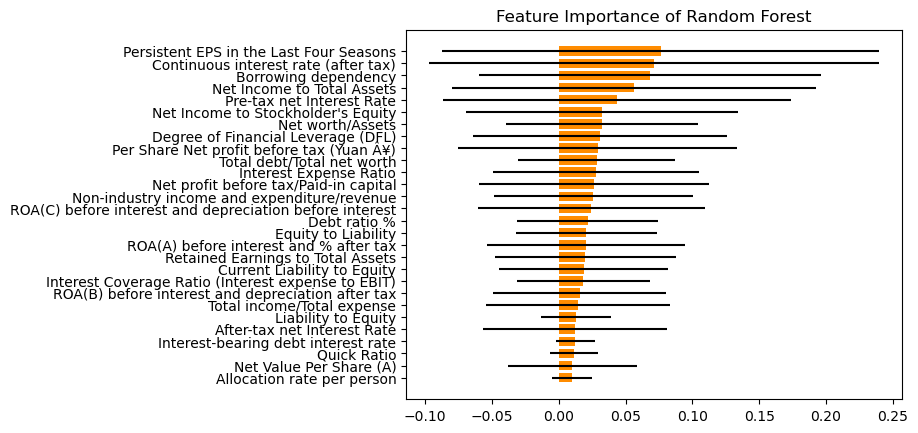

In [305]:
fig, ax = plt.subplots()
feature_selection_rf_filtered = feature_selection_rf[feature_selection_rf['Importance'] > 0.01].sort_values(by='Importance', ascending=True)
ax.barh(feature_selection_rf_filtered.index, feature_selection_rf_filtered['Importance'], color='darkorange', xerr=feature_selection_rf_filtered['std'])
ax.set_title('Feature Importance of Random Forest')
plt.show()

#### Support Vector Machine <a class="anchor" id="6.5"></a>

[Table of Contents](#0.1)

In [201]:
# Initialize the classifier and its name
classifier_name = 'SVM'
classifier = SVC(kernel="linear", random_state=random_state, probability=True)

In [202]:
selector = RFECV(classifier, step=1, cv=5, scoring=make_scorer(fbeta_score, beta=2))
selector.fit(X, y)

RFECV(cv=5, estimator=SVC(kernel='linear', probability=True, random_state=42),
      scoring=make_scorer(fbeta_score, beta=2))

In [203]:
df_cleaned.iloc[:, 1: ].loc[:, selector.support_]

,Total debt/Total net worth,Net worth/Assets,Borrowing dependency,Net Worth Turnover Rate (times),Working Capital/Equity,Current Liabilities/Equity,Liability-Assets Flag,Net Income to Stockholder's Equity,Liability to Equity
0,0.021266,0.792424,0.390284,0.032903,0.721275,0.339077,0,0.827890,0.290202
1,0.012502,0.828824,0.376760,0.025484,0.731975,0.329740,0,0.839969,0.283846
3,0.009572,0.848535,0.379743,0.028065,0.729825,0.331509,0,0.834697,0.281721
4,0.005150,0.893491,0.375025,0.040161,0.732000,0.330726,0,0.839973,0.278514
5,0.014213,0.819573,0.381448,0.029677,0.725202,0.335534,0,0.829939,0.285087
...,...,...,...,...,...,...,...,...,...
6811,0.003874,0.912114,0.373569,0.015323,0.733682,0.327194,0,0.841355,0.277588
6813,0.009026,0.852919,0.374587,0.027903,0.731959,0.331098,0,0.839864,0.281325
6814,0.006655,0.875382,0.373823,0.027903,0.736716,0.330914,0,0.840359,0.279606
6815,0.004623,0.900747,0.372505,0.027419,0.734584,0.329753,0,0.840306,0.278132


In [204]:
X_RFE_1 = X[:, selector.support_]

In [205]:
X_RFE_1

array([[0.02126592, 0.79242374, 0.39028435, ..., 0.        , 0.82789021,
        0.29020189],
       [0.01250239, 0.82882365, 0.37676002, ..., 0.        , 0.83996927,
        0.28384598],
       [0.0095724 , 0.84853524, 0.37974269, ..., 0.        , 0.83469711,
        0.28172119],
       ...,
       [0.00665518, 0.87538169, 0.37382321, ..., 0.        , 0.84035896,
        0.27960554],
       [0.00462342, 0.90074674, 0.37250466, ..., 0.        , 0.84030574,
        0.27813214],
       [0.00139159, 0.96106056, 0.36963718, ..., 0.        , 0.84013826,
        0.27578866]])

model: SVM
The best parameter is: {'SVM__C': 0.1}
Confusion Matrix:



,Predicted Negative,Predicted Positive
Actual Negative,5234,856
Actual Positive,43,148


Model metrics:
precision            0.171464
recall               0.868691
f1                   0.281478
f2                   0.463889
average_precision    0.398291
roc_auc              0.919760
type1_error          0.140558
type2_error          0.225131
dtype: float64


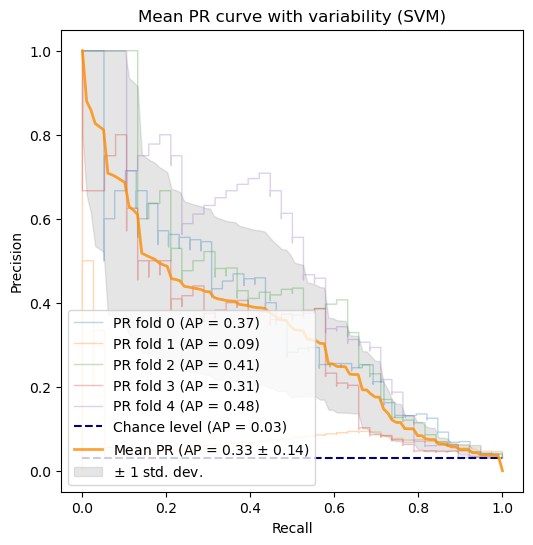

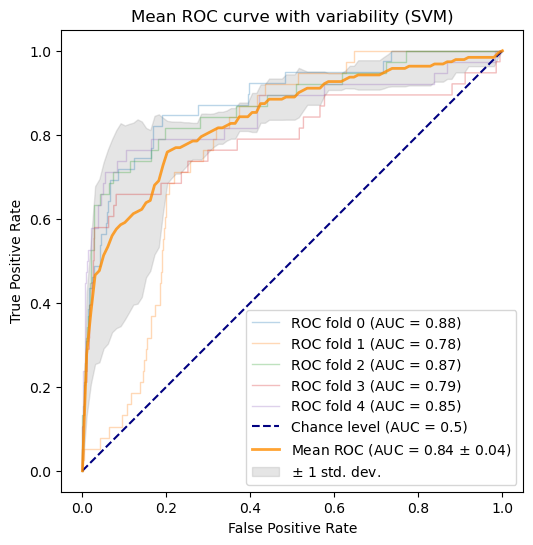

In [213]:
# Generate the pipeline
pipe = get_pipe(classifier_name, classifier)

# Grid search tuning params
grid_params = {classifier_name + '__' + 'C': [0.1, 1, 10, 100]}
search_svm = GridSearchCV(pipe, param_grid=grid_params, scoring=SCOREING_METHOD, n_jobs=N_JOBS, refit=REFIT, cv=CV_NUM)
search_svm.fit(X_RFE_1, y)

# Summarize the results
print('model:', classifier_name)
print('The best parameter is:', search_svm.best_params_)
data = [search_svm.cv_results_['mean_test_' + scorer][search_svm.best_index_] for scorer in SCOREING_METHOD.keys()]
index = [scorer for scorer in SCOREING_METHOD.keys()]
result_cv_svm = pd.Series(data=data, index=index, name=classifier_name)

# Predict probabilities with cv and calculate type1 and type2 error
y_pred_proba_svm = cross_val_predict(search_svm.best_estimator_, X, y, cv=CV_NUM, method='predict_proba')[:, 1]  # proba of label 1
type1_error, type2_error = calculate_type1_type2_error(y, np.where(y_pred_proba_svm > 0.5, 1, 0), display_cm=True)  # use 0.5 as threshold by default
result_cv_svm = pd.concat([result_cv_svm, pd.Series(data=[type1_error, type2_error], index=['type1_error', 'type2_error'])])
print('Model metrics:\n', result_cv_svm, sep='')

# Plot PR curve and ROC
plot_PR_curve(search_svm.best_estimator_, classifier_name, CV_NUM)
plot_ROC(search_svm.best_estimator_, classifier_name, CV_NUM)

In [317]:
# save and load model
model_path_svm = './fitted_models/model_svm.pkl'

if os.path.exists(model_path_svm):
    # Load the best model with pickle
    with open(model_path_svm, 'rb') as f:
        search_svm = pickle.load(f)
        best_model_svm = search_svm.best_estimator_
elif 'search_svm' in globals():
    # Dump the best model with pickle
    with open(model_path_svm, 'wb') as f:
        pickle.dump(search_svm, f)

In [318]:
selected_col_names = [col_names[idx] for idx in range(len(col_names)) if selector.support_[idx]]

In [319]:
# feature importance of logistic regression (criteria: abs of coef)
feature_selection_svm = pd.DataFrame(index=selected_col_names, data=best_model_svm.named_steps['SVM'].coef_.T, columns=['coef'])
feature_selection_svm['abs_coef'] = np.abs(feature_selection_svm['coef'])
feature_selection_svm.sort_values(by='abs_coef', ascending=False, inplace=True)
feature_selection_svm = feature_selection_svm.loc[~(feature_selection_svm == 0).any(axis=1), :]
feature_selection_svm

,coef,abs_coef
Net Income to Stockholder's Equity,-3.155194,3.155194
Liability to Equity,-1.878466,1.878466
Net worth/Assets,-1.506562,1.506562
Liability-Assets Flag,1.321881,1.321881
Borrowing dependency,1.116046,1.116046
Net Worth Turnover Rate (times),-0.609238,0.609238
Current Liabilities/Equity,0.581029,0.581029
Total debt/Total net worth,-0.496261,0.496261
Working Capital/Equity,-0.079589,0.079589


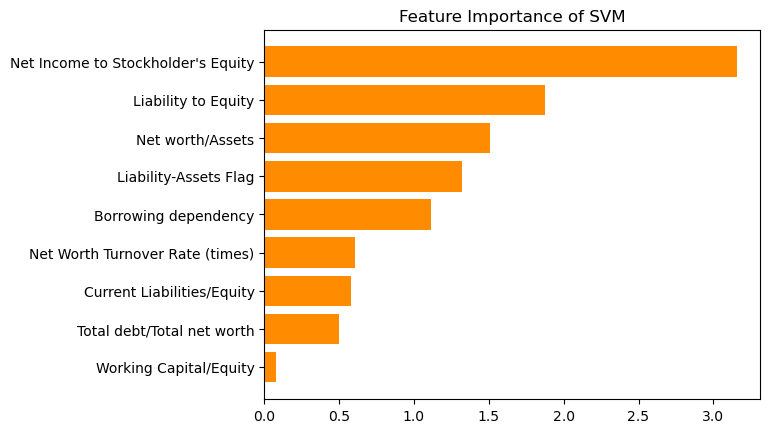

In [320]:
fig, ax = plt.subplots()
feature_selection_svm_filtered = feature_selection_svm['abs_coef'].sort_values(ascending=True)
ax.barh(feature_selection_svm_filtered.index, feature_selection_svm_filtered, color='darkorange')
ax.set_title('Feature Importance of SVM')
plt.show()

#### XGBoost <a class="anchor" id="6.6"></a>

[Table of Contents](#0.1)

model: XGB
The best parameter is: OrderedDict([('XGB__colsample_bytree', 0.7222222222222222), ('XGB__gamma', 5.444444444444445), ('XGB__max_depth', 15), ('XGB__min_child_weight', 1), ('XGB__n_estimators', 200), ('XGB__reg_alpha', 58), ('XGB__reg_lambda', 0.3333333333333333)])
Confusion Matrix:



,Predicted Negative,Predicted Positive
Actual Negative,5537,553
Actual Positive,50,141


Model metrics:
precision            0.233683
recall               0.737787
f1                   0.346332
f2                   0.497365
average_precision    0.350627
roc_auc              0.929120
type1_error          0.090805
type2_error          0.261780
dtype: float64


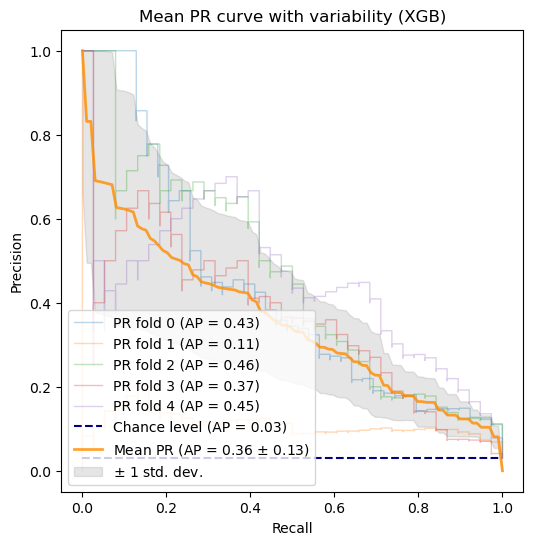

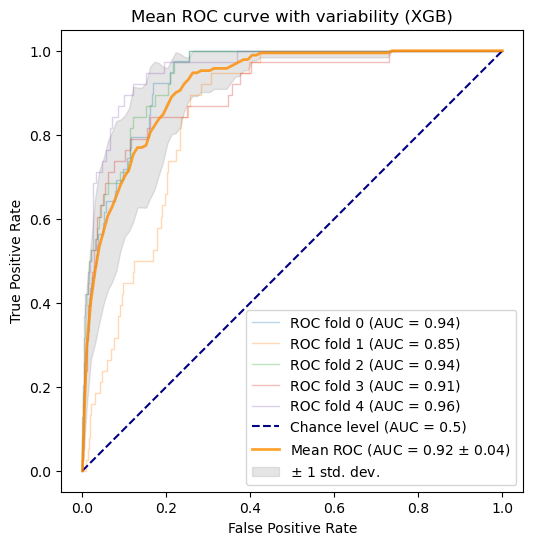

In [134]:
# Fix an issue caused by the version mismatch of skopt and numpy
np.int = np.int64

# Initialize the classifier and its name
classifier_name = 'XGB'
classifier = xgb.XGBClassifier(random_state=random_state)

# Generate the pipeline
pipe = get_pipe(classifier_name, classifier)

# Grid search tuning params
grid_params = {classifier_name + '__' + 'max_depth': np.arange(3, 18, 1),
               classifier_name + '__' + 'gamma': np.linspace(1, 9, 10),
               classifier_name + '__' + 'reg_alpha': np.arange(40, 180, 1),
               classifier_name + '__' + 'reg_lambda': np.linspace(0, 1, 10),
               classifier_name + '__' + 'colsample_bytree': np.linspace(0.5, 1, 10),
               classifier_name + '__' + 'min_child_weight': np.arange(0, 10, 1),
               classifier_name + '__' + 'n_estimators': [100, 200, 300]}
search_xgb = BayesSearchCV(pipe, search_spaces=grid_params, scoring=make_scorer(fbeta_score, beta=2), n_jobs=N_JOBS, refit=True, cv=CV_NUM)
search_xgb.fit(X, y)

# Summarize the results
print('model:', classifier_name)
print('The best parameter is:', search_xgb.best_params_)
xgb_cv_results = cross_validate(search_xgb.best_estimator_, X, y, scoring=SCOREING_METHOD, cv=CV_NUM, n_jobs=N_JOBS)
data = [xgb_cv_results['test_' + scorer].mean() for scorer in SCOREING_METHOD.keys()]
index = [scorer for scorer in SCOREING_METHOD.keys()]
result_cv_xgb = pd.Series(data=data, index=index, name=classifier_name)

# Predict probabilities with cv and calculate type1 and type2 error
y_pred_proba_xgb = cross_val_predict(search_xgb.best_estimator_, X, y, cv=CV_NUM, method='predict_proba')[:, 1]  # proba of label 1
type1_error, type2_error = calculate_type1_type2_error(y, np.where(y_pred_proba_xgb > 0.5, 1, 0), display_cm=True)  # use 0.5 as threshold by default
result_cv_xgb = pd.concat([result_cv_xgb, pd.Series(data=[type1_error, type2_error], index=['type1_error', 'type2_error'])])
print('Model metrics:\n', result_cv_xgb, sep='')

# Plot PR curve and ROC
plot_PR_curve(search_xgb.best_estimator_, classifier_name, CV_NUM)
plot_ROC(search_xgb.best_estimator_, classifier_name, CV_NUM)

In [307]:
# save and load model
model_path_xgb = './fitted_models/model_xgb.pkl'

if os.path.exists(model_path_xgb):
    # Load the best model with pickle
    with open(model_path_xgb, 'rb') as f:
        search_xgb = pickle.load(f)
        best_model_xgb = search_xgb.best_estimator_
elif 'search_xgb' in globals():
    # Dump the best model with pickle
    with open(model_path_xgb, 'wb') as f:
        pickle.dump(search_xgb, f)

In [308]:
# feature importance of xgboost
feature_selection_xgb = pd.DataFrame(index=col_names, data=best_model_xgb.named_steps['XGB'].feature_importances_, columns=['Importance']).sort_values(by='Importance', ascending=False)
feature_selection_xgb = feature_selection_xgb.loc[~(feature_selection_xgb == 0).any(axis=1), :]
feature_selection_xgb

,Importance
Continuous interest rate (after tax),0.217243
Net worth/Assets,0.127409
Non-industry income and expenditure/revenue,0.120140
Borrowing dependency,0.071795
Degree of Financial Leverage (DFL),0.064310
...,...
Inventory and accounts receivable/Net value,0.001491
Net profit before tax/Paid-in capital,0.001441
Cash Reinvestment %,0.001388
Operating profit/Paid-in capital,0.001139


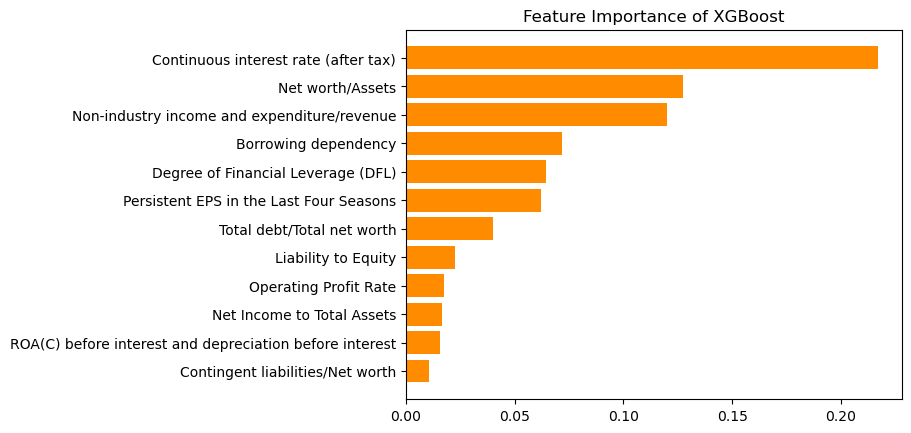

In [309]:
fig, ax = plt.subplots()
feature_selection_xgb_filtered = feature_selection_xgb[feature_selection_xgb['Importance'] > 0.01].sort_values(by='Importance', ascending=True)
ax.barh(feature_selection_xgb_filtered.index, feature_selection_xgb_filtered['Importance'], color='darkorange')
ax.set_title('Feature Importance of XGBoost')
plt.show()

### Comparison of Models <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

In [310]:
model_names = ['Logistic', 'Tree', 'RF', 'SVM', 'XGB']
metrics_summary = pd.concat([result_cv_logistic, result_cv_tree, result_cv_rf, result_cv_svm, result_cv_xgb], axis=1).rename(columns={i: model_names[i] for i in range(len(model_names))})
metrics_summary.round(4)

,Logistic,Tree,RF,SVM,XGB
precision,0.1694,0.1631,0.2242,0.1715,0.2337
recall,0.8687,0.7059,0.6904,0.8687,0.7378
f1,0.2800,0.2599,0.3315,0.2815,0.3463
f2,0.4647,0.4097,0.4734,0.4639,0.4974
average_precision,0.3808,0.1993,0.3456,0.3983,0.3506
roc_auc,0.9210,0.8098,0.9260,0.9198,0.9291
type1_error,0.1512,0.1291,0.0867,0.1406,0.0908
type2_error,0.1309,0.2932,0.3089,0.2251,0.2618
